In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import relu
from PIL import Image
from torch import nn, optim

This dataset has been annotated among four different radiologists for 5 of our 14 pathologies:

- Consolidation
- Edema
- Effusion
- Cardiomegaly
- Atelectasis

Each pathology is marked with `0` (negative) or `1` (positive) for the specified pathology

### Getting the data

In [2]:
train_filepath = "/kaggle/input/nih-dataset/train-small.csv"
valid_filepath = "/kaggle/input/nih-dataset/valid-small.csv"
test_filepath = "/kaggle/input/nih-dataset/test.csv"

train_df = pd.read_csv(train_filepath)
valid_df = pd.read_csv(valid_filepath)
test_df = pd.read_csv(test_filepath)

In [3]:
print(train_df.shape)
train_df.head()

(1000, 16)


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [4]:
print(valid_df.shape)
valid_df.head()

(109, 16)


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00027623_007.png,0,0,0,1,1,0,0,0,0,0,0,27623,0,0,0
1,00028214_000.png,0,0,0,0,0,0,0,0,0,0,0,28214,0,0,0
2,00022764_014.png,0,0,0,0,0,0,0,0,0,0,0,22764,0,0,0
3,00020649_001.png,1,0,0,0,1,0,0,0,0,0,0,20649,0,0,0
4,00022283_023.png,0,0,0,0,0,0,0,0,0,0,0,22283,0,0,0


In [5]:
print(test_df.shape)
test_df.head()

(420, 16)


,Image,PatientId,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00021463_005.png,21463,0,0,1,1,1,0,0,1,0,0,0,0,1,0
1,00019733_002.png,19733,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,00021463_001.png,21463,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00017136_020.png,17136,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,00027477_000.png,27477,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

In [7]:
print(f"The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")

The total patient ids are 1000, from those the unique ids are 928 


In [8]:
columns = list(train_df.keys())
columns

['Image',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'PatientId',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [9]:
columns.remove('Image')
columns.remove('PatientId')

print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [10]:
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


### Data Leakage

In [11]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    return bool(set(df1[patient_col]).intersection(set(df2[patient_col])))

In [12]:
print("Check Leakage")
print("=====================================")

print("Test case 1")
df1 = pd.DataFrame({'PatientId': [0, 1, 2]})
df2 = pd.DataFrame({'PatientId': [2, 3, 4]})
print(f"leakage output: {check_for_leakage(df1, df2, 'PatientId')}")

print("-------------------------------------")

print("Test case 2")
df1 = pd.DataFrame({'PatientId': [0, 1, 2]})
df2 = pd.DataFrame({'PatientId': [3, 4, 5]})
print(f"leakage output: {check_for_leakage(df1, df2, 'PatientId')}")

Check Leakage
Test case 1
leakage output: True
-------------------------------------
Test case 2
leakage output: False


In [13]:
print(f"Leakeage between train and validation sets: {check_for_leakage(train_df, valid_df, 'PatientId')}")
print(f"Leakeage between train and test sets: {check_for_leakage(train_df, test_df, 'PatientId')}")
print(f"Leakeage between validation and test sets: {check_for_leakage(valid_df, test_df, 'PatientId')}")

Leakeage between train and validation sets: True
Leakeage between train and test sets: False
Leakeage between validation and test sets: False


In [14]:
overlapping_patient_ids = set(train_df["PatientId"]).intersection(set(valid_df["PatientId"]))
num_of_overlaps = len(overlapping_patient_ids)
print(f"Number of unique overlaps between train and validation sets: {num_of_overlaps}")
print(f"These are the overlapping patient IDs: {overlapping_patient_ids}")

Number of unique overlaps between train and validation sets: 11
These are the overlapping patient IDs: {20290, 27618, 9925, 10888, 22764, 19981, 18253, 4461, 28208, 8760, 7482}


### Removing overlapping patients from validations set

In [15]:
print(f"Current validation set shape: {valid_df.shape}")
valid_df = valid_df[~valid_df["PatientId"].isin(overlapping_patient_ids)]
print(f"New validation set shape (without overlapping patients): {valid_df.shape}")

Current validation set shape: (109, 16)
New validation set shape (without overlapping patients): (96, 16)


In [16]:
print(f"Leakeage between train and validation sets: {check_for_leakage(train_df, valid_df, 'PatientId')}")

Leakeage between train and validation sets: False


Display Random Images


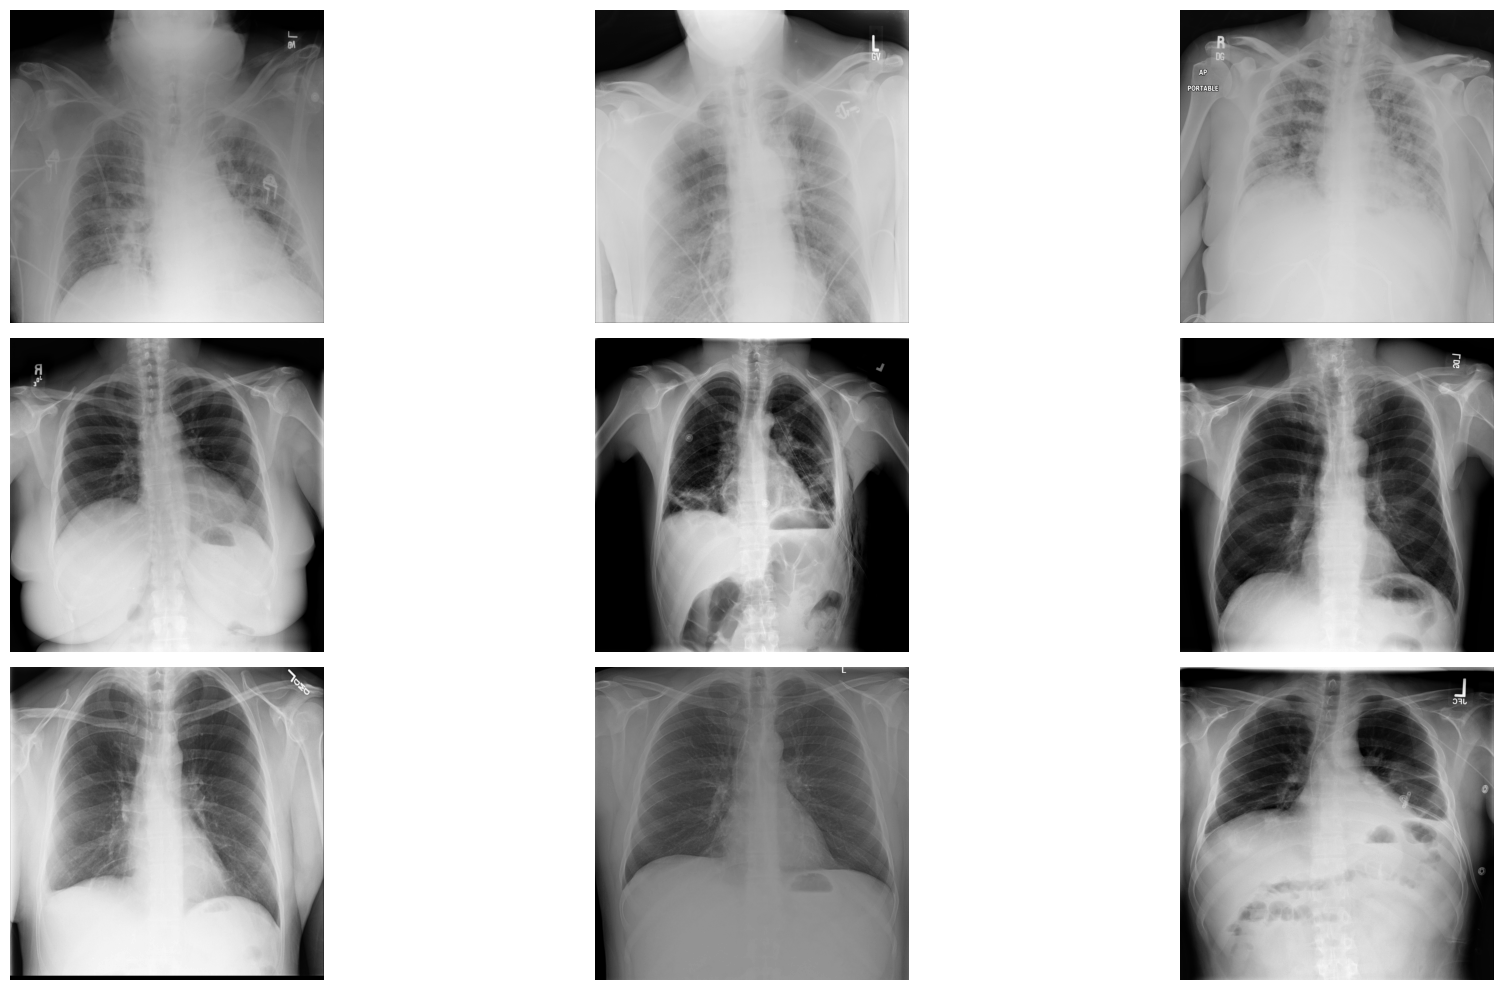

In [17]:
images = train_df['Image'].values
random_images = [np.random.choice(images) for i in range(9)]

img_dir = '/kaggle/input/images/images-small/'

print('Display Random Images')

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()    

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 (white) and the minimum is 0.0000 (black)
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


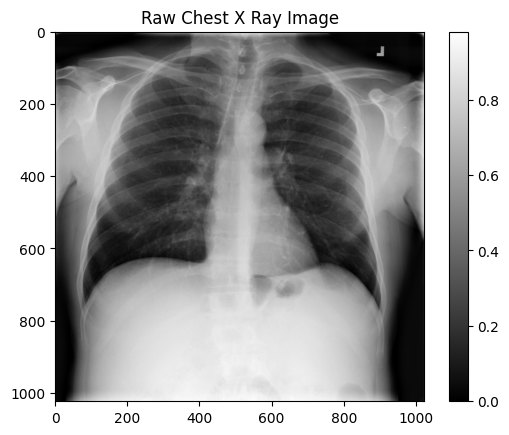

In [18]:
img = train_df.Image[0]
image = plt.imread(os.path.join(img_dir, img))
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {image.shape[0]} pixels width and {image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {image.max():.4f} (white) and the minimum is {image.min():.4f} (black)")
print(f"The mean value of the pixels is {image.mean():.4f} and the standard deviation is {image.std():.4f}")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


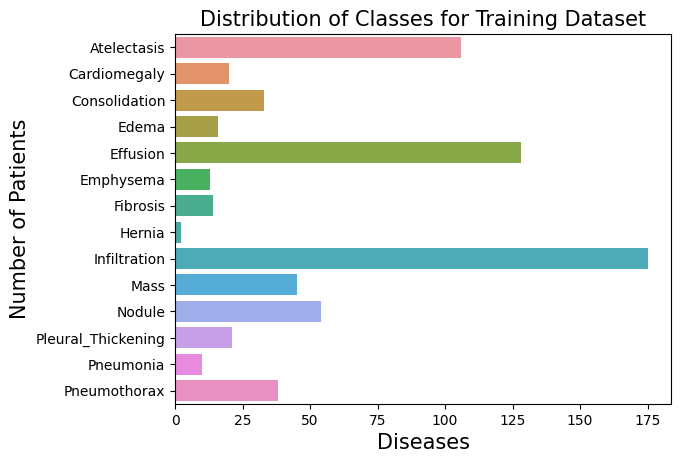

In [19]:
label_count = []

for column in columns:
    label_count.append(train_df[column].sum())

sns.barplot(x=label_count, y=columns)
plt.title('Distribution of Classes for Training Dataset', fontsize=15)
plt.ylabel('Number of Patients', fontsize=15)
plt.xlabel('Diseases', fontsize=15)
plt.show()

### Data Management

- Preprocess images
- Create a custom dataset
- Create a dataloader

In [20]:
class CustomImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_name = self.df.iloc[index]["Image"]
        labels = self.df.iloc[index].filter(items=columns)
        labels = torch.tensor(labels, dtype=torch.float32)

        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, labels

In [21]:
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),
        scale=(0.8, 1.2),
        shear=20
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # The mean for R, G, B channels
        std=[0.229, 0.224, 0.225]  # The standard deviation for R, G, B channels
    )
])

Debugging transforms

In [22]:
raw_dataset = CustomImageDataset(
    df=train_df,
    image_dir="/kaggle/input/images/images-small/"
)

image, label = raw_dataset[0]

print(f"Raw image: {image.size}")
image = transforms.Resize((320, 320))(image)
print(f"Resized image: {image.size}")
image = transforms.RandomHorizontalFlip()(image)
print(f"Random flipped image: {image.size}")
image = transforms.RandomRotation(20)(image)
print(f"Random rotated image: {image.size}")
image = transforms.RandomAffine(
    degrees=0,
    translate=(0.2, 0.2),
    scale=(0.8, 1.2),
    shear=20
)(image)
print(f"Random affine image: {image.size}")
image = transforms.ToTensor()(image)
print(f"Tensor image: {image.shape}, range[{image.min():.1f}, {image.max():.1f}]")
image = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], # The mean for R, G, B channels
    std=[0.229, 0.224, 0.225]  # The standard deviation for R, G, B channels
)(image)
print(f"Normalized image: {image.shape}, range[{image.min():.1f}, {image.max():.1f}]")

Raw image: (1024, 1024)
Resized image: (320, 320)
Random flipped image: (320, 320)
Random rotated image: (320, 320)
Random affine image: (320, 320)
Tensor image: torch.Size([3, 320, 320]), range[0.0, 0.9]
Normalized image: torch.Size([3, 320, 320]), range[-2.1, 2.3]


/tmp/ipykernel_13/951427062.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labels, dtype=torch.float32)


In [23]:
dataset = CustomImageDataset(
    df=train_df,
    transform=transform,
    image_dir="/kaggle/input/images/images-small/"
)

In [24]:
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
)

In [25]:
data_iter = iter(dataloader)
batch = next(data_iter)
images, labels = batch
images.shape, labels.shape

/tmp/ipykernel_13/951427062.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labels, dtype=torch.float32)


(torch.Size([64, 3, 320, 320]), torch.Size([64, 14]))

torch.Size([3, 320, 320])
The dimensions of the transformed_image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.5354 and the minimum is -2.1179
The mean value of the pixels is 0.0182 and the standard deviation is 1.3844


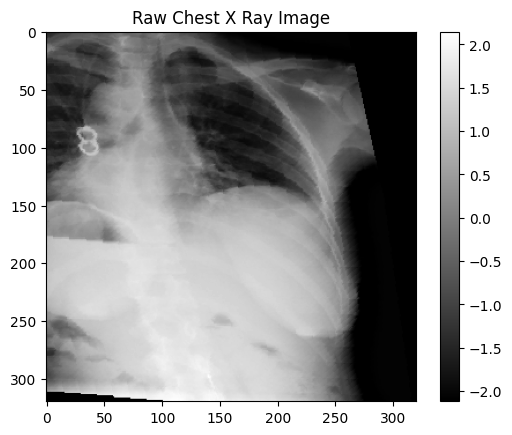

In [26]:
transformed_image = images[0]

plt.imshow(transformed_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(transformed_image.shape)
print(f"The dimensions of the transformed_image are {transformed_image.shape[1]} pixels width and {transformed_image.shape[2]} pixels height")
print(f"The maximum pixel value is {transformed_image.max():.4f} and the minimum is {transformed_image.min():.4f}")
print(f"The mean value of the pixels is {transformed_image.mean():.4f} and the standard deviation is {transformed_image.std():.4f}")

### Class Imbalanced

The Hernia class, with only 2 positive samples, results in a $\text{pos\_weight}$ of $499.0$.

In nn.BCEWithLogitsLoss, the $\text{pos\_weight}$ acts as a multiplier for the loss generated by a positive sample. A weight of $499.0$ means that misclassifying a single positive sample for "Hernia" generates a loss 499 times greater than misclassifying a negative sample.

If a batch contains one of these rare "Hernia" positive cases and the model predicts poorly for it, the loss contribution for that single class can become so dominant that it:

- Overwhelms the gradients from the other 13 classes.
- Forces massive, unstable updates to the model weights.
- Prevents convergence on the overall dataset, leading to the observed high loss plateau.

In [27]:
label_condition_incidence = pd.DataFrame({"Condition": [], "Positive Count": [], "Negative Count": []})

samples_count = train_df.shape[0]

print(f"Samples count: {samples_count}")
print("===================")

for column in columns:
    positive_label_count = train_df[column].sum()
    negative_label_count = samples_count - positive_label_count
    pos_weight = negative_label_count / positive_label_count
    label_condition_incidence = pd.concat([
        label_condition_incidence,
        pd.DataFrame({
            "Condition": [column],
            "Positive Count": [positive_label_count],
            "Negative Count": [negative_label_count],
            "Pos Weight": [pos_weight]
        })
    ], ignore_index=True)
    print(f"The class {column} has {positive_label_count} positive samples and {negative_label_count} negative samples with pos_weight of {pos_weight}")

label_condition_incidence

Samples count: 1000
The class Atelectasis has 106 positive samples and 894 negative samples with pos_weight of 8.433962264150944
The class Cardiomegaly has 20 positive samples and 980 negative samples with pos_weight of 49.0
The class Consolidation has 33 positive samples and 967 negative samples with pos_weight of 29.303030303030305
The class Edema has 16 positive samples and 984 negative samples with pos_weight of 61.5
The class Effusion has 128 positive samples and 872 negative samples with pos_weight of 6.8125
The class Emphysema has 13 positive samples and 987 negative samples with pos_weight of 75.92307692307692
The class Fibrosis has 14 positive samples and 986 negative samples with pos_weight of 70.42857142857143
The class Hernia has 2 positive samples and 998 negative samples with pos_weight of 499.0
The class Infiltration has 175 positive samples and 825 negative samples with pos_weight of 4.714285714285714
The class Mass has 45 positive samples and 955 negative samples with 

,Condition,Positive Count,Negative Count,Pos Weight
0,Atelectasis,106.0,894.0,8.433962
1,Cardiomegaly,20.0,980.0,49.000000
2,Consolidation,33.0,967.0,29.303030
3,Edema,16.0,984.0,61.500000
4,Effusion,128.0,872.0,6.812500
5,Emphysema,13.0,987.0,75.923077
6,Fibrosis,14.0,986.0,70.428571
7,Hernia,2.0,998.0,499.000000
8,Infiltration,175.0,825.0,4.714286
9,Mass,45.0,955.0,21.222222


### Model Training

Loss function: weighted binary cross entropy loss

In [28]:
# Square root creates a balance between attention and stability
pos_weight = torch.sqrt(torch.tensor(label_condition_incidence["Pos Weight"]))
pos_weight

tensor([ 2.9041,  7.0000,  5.4132,  7.8422,  2.6101,  8.7134,  8.3922, 22.3383,
         2.1712,  4.6068,  4.1855,  6.8278,  9.9499,  5.0315],
       dtype=torch.float64)

In [29]:
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_function

BCEWithLogitsLoss()

In [30]:
images, labels = batch
images.shape, labels.shape

(torch.Size([64, 3, 320, 320]), torch.Size([64, 14]))

Overfitting to a single batch to make sure the model is learning

In [31]:
# data_iter = iter(dataloader)
# batch = next(data_iter)
# images, labels = batch

# for epoch in range(100):
#     optimizer.zero_grad()
#     output = model(images)
#     loss = loss_function(output, labels.float())
#     loss.backward()
#     optimizer.step()

#     print(f'Epoch {epoch + 1}, Loss: {loss}')

### CNN equations

Convolution:
$H_{\text{out}} = [(H_{\text{in}} - K + 2P) / S] + 1$

MaxPooling:
$H_{\text{out}} = [(H_{\text{in}} - K) / S] + 1$

- $H_{\text{in}}$ = Input Height/Width
- $K$ = kernel_size (3 for all conv layers)
- $P$ = padding (1 for all conv layers)
- $S$ = stride (defaults to 1 for all conv layers)

### Applying equations

- Shape: `(3, 320, 320)`
- Conv1: $320 = [(320 - 3 + 2*1) / 1] + 1$
- Pool1: $160 = [(320 - 2) / 2] + 1$
- Conv2: $160 = [(160 - 3 + 2*1) / 1] + 1$
- Pool2: $80 = [(160 - 2) / 2] + 1$
- Conv3: $80 = [(80 - 3 + 2*1) / 1] + 1$
- Pool3: $40 = [(80 - 2) / 2] + 1$
- Conv4: $40 = [(40 - 3 + 2*1) / 1] + 1$
- Pool4: $20 = [(40 - 2) / 2] + 1$

Final output of the convolution layer is `(B, 128, 20, 20)`

- $C = 128$
- $H = 20$
- $W = 20$

In [32]:
class XRayCNN(nn.Module):
    def __init__(self):
        super(XRayCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # flattening the 3d structure: 128 (Channels) * 20 (Height) * 20 (Width)
        self.fc1 = nn.Linear(128 * 20 * 20, 1024)
        self.dropout = nn.Dropout(0.25)
        # 14 pathology classes
        self.fc2 = nn.Linear(1024, 14)

    def forward(self, x):
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = self.pool(relu(self.conv3(x)))
        x = self.pool(relu(self.conv4(x)))
        x = x.view(-1, 128 * 20 * 20)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [33]:
model = XRayCNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_function(output, labels)
        running_loss += loss
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

/tmp/ipykernel_13/951427062.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labels, dtype=torch.float32)


Epoch 1, Loss: 0.5448
Epoch 2, Loss: 0.4974
Epoch 3, Loss: 0.4877
Epoch 4, Loss: 0.4861
Epoch 5, Loss: 0.4796


with bigger learning rate

In [34]:
model = XRayCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_function(output, labels)
        running_loss += loss
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

/tmp/ipykernel_13/951427062.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labels, dtype=torch.float32)


Epoch 1, Loss: 0.5624
Epoch 2, Loss: 0.5013
Epoch 3, Loss: 0.4950
Epoch 4, Loss: 0.4872
Epoch 5, Loss: 0.4885


Without squared pos weight

In [35]:
pos_weight = torch.tensor(label_condition_incidence["Pos Weight"])
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
model = XRayCNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_function(output, labels)
        running_loss += loss
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

/tmp/ipykernel_13/951427062.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labels, dtype=torch.float32)


Epoch 1, Loss: 1.4062
Epoch 2, Loss: 1.3236
Epoch 3, Loss: 1.3273
Epoch 4, Loss: 1.3093
Epoch 5, Loss: 1.3063


### Transfer Learning

In [36]:
from torchvision import models

class TransferLearningXRay(nn.Module):
    def __init__(self, num_classes=14):
        super(TransferLearningXRay, self).__init__()
        # Load a pre-trained ResNet18
        # "pretrained=True" downloads weights learned on ImageNet
        self.base_model = models.resnet18(pretrained=True)
        
        # Replace the last layer (fc) to match your 14 classes
        # ResNet18's last layer input size is 512
        in_features = self.base_model.fc.in_features 
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [37]:
pos_weight = torch.sqrt(torch.tensor(label_condition_incidence["Pos Weight"]))
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
model = TransferLearningXRay()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 50

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_function(output, labels)
        running_loss += loss
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 320MB/s]
/tmp/ipykernel_13/951427062.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

Epoch 1, Loss: 0.7139
Epoch 2, Loss: 0.5365
Epoch 3, Loss: 0.4623
Epoch 4, Loss: 0.4227
Epoch 5, Loss: 0.4038
Epoch 6, Loss: 0.3863
Epoch 7, Loss: 0.3614
Epoch 8, Loss: 0.3394
Epoch 9, Loss: 0.3258
Epoch 10, Loss: 0.3126
Epoch 11, Loss: 0.2834
Epoch 12, Loss: 0.2787
Epoch 13, Loss: 0.2668
Epoch 14, Loss: 0.2482
Epoch 15, Loss: 0.2328
Epoch 16, Loss: 0.2202
Epoch 17, Loss: 0.2116
Epoch 18, Loss: 0.1967
Epoch 19, Loss: 0.1832
Epoch 20, Loss: 0.1735
Epoch 21, Loss: 0.1674
Epoch 22, Loss: 0.1555
Epoch 23, Loss: 0.1455
Epoch 24, Loss: 0.1386
Epoch 25, Loss: 0.1312
Epoch 26, Loss: 0.1180
Epoch 27, Loss: 0.1177
Epoch 28, Loss: 0.1105
Epoch 29, Loss: 0.1004
Epoch 30, Loss: 0.0930
Epoch 31, Loss: 0.0900
Epoch 32, Loss: 0.0821
Epoch 33, Loss: 0.0764
Epoch 34, Loss: 0.0738
Epoch 35, Loss: 0.0700
Epoch 36, Loss: 0.0714
Epoch 37, Loss: 0.0661
Epoch 38, Loss: 0.0624
Epoch 39, Loss: 0.0610
Epoch 40, Loss: 0.0550
Epoch 41, Loss: 0.0525
Epoch 42, Loss: 0.0476
Epoch 43, Loss: 0.0433
Epoch 44, Loss: 0.04